# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import re
import sys
import pickle

#scikit
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

### `0.1` Data Understanding

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


#### `0.1.1` Convert float data to int

Convert float data to int if possible

In [5]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [6]:
azdias = azdias.convert_dtypes(convert_string=False)

In [7]:
azdias.dtypes.value_counts()

Int64     360
object      6
dtype: int64

In [8]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [9]:
customers = customers.convert_dtypes(convert_string=False)

In [10]:
customers.dtypes.value_counts()

Int64     361
object      8
dtype: int64

#### `0.1.2` Removing unknown values

**Strategy**
* Read the Excel Attributes
* Eliminate all Unkown value and replace by nan

In [11]:
azdias_attr = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header = 1, usecols = "B:E")

In [12]:
azdias_attr.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


Each row with a value in `Attribute` is the first element of a group, so let's fill in the empty values through a front fill.

First, let's check if there is any empty data in `Value`

In [13]:
azdias_attr.Value.hasnans

False

There is no empty values in `Value`, so let's proceed with the front fill.

In [14]:
azdias_attr = azdias_attr.ffill()

In [15]:
azdias_attr.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [16]:
pat = re.compile('[Uu]nknown')

In [17]:
unknows_id = [(re.search(pat, txt) is not None )for txt in azdias_attr.Meaning]

In [18]:
azdias_attr[unknows_id]

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [19]:
cols = np.intersect1d(azdias.columns.values, azdias_attr[unknows_id]['Attribute'].values)

In [20]:
print(f"{len(cols)} cols with Unkown values")

225 cols with Unkown values


In [21]:
replacement = dict()
for col in cols:
    values = azdias_attr[unknows_id].query('Attribute == @col').Value.values
    if isinstance(values[0], str):
        values = values[0].split(',')
        values = map(int, values)
    aux = dict()
    for i in values:
        aux[i] = np.nan
    replacement[col] = aux

In [22]:
azdias = azdias.replace(replacement)

In [23]:
customers = customers.replace(replacement)

#### `0.1.3` Convert some data types to the appropriate data types

In [24]:
azdias_nuniques = azdias.nunique()

In [25]:
azdias_nuniques

LNR                     891221
AGER_TYP                     4
AKT_DAT_KL                   9
ALTER_HH                    21
ALTER_KIND1                 17
                         ...  
WOHNDAUER_2008               9
WOHNLAGE                     8
ZABEOTYP                     6
ANREDE_KZ                    2
ALTERSKATEGORIE_GROB         5
Length: 366, dtype: int64

In [26]:
azdias[azdias_nuniques[azdias_nuniques > 99].index.values]

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,EINGEFUEGT_AM,GEBURTSJAHR,KBA13_ANZAHL_PKW
0,910215,<NA>,<NA>,NaN,0,<NA>
1,910220,11,12,1992-02-10 00:00:00,1996,963
2,910225,10,7,1992-02-12 00:00:00,1979,712
3,910226,1,2,1997-04-21 00:00:00,1957,596
4,910241,3,3,1992-02-12 00:00:00,1963,435
...,...,...,...,...,...,...
891216,825761,15,11,1992-02-10 00:00:00,1976,282
891217,825771,11,11,1992-02-10 00:00:00,1970,592
891218,825772,3,3,1992-02-10 00:00:00,1976,688
891219,825776,7,5,1992-02-12 00:00:00,1994,134


`EINGEFUEGT_AM` shoud be date format instead of object

In [27]:
azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'])

In [28]:
azdias['EINGEFUEGT_AM'].dtypes

dtype('<M8[ns]')

In [29]:
azdias.dtypes.value_counts()

Int64             360
object              5
datetime64[ns]      1
dtype: int64

In [30]:
customers['EINGEFUEGT_AM'] = pd.to_datetime(customers['EINGEFUEGT_AM'])

#### `0.1.4` Exploratory analysis

Let's take a look the extra variables in customers

In [31]:
cust_cols = np.setdiff1d(customers.columns, azdias.columns)

In [32]:
customers[cust_cols].nunique()

CUSTOMER_GROUP     2
ONLINE_PURCHASE    2
PRODUCT_GROUP      3
dtype: int64

In [33]:
customers_groups =  customers[cust_cols].groupby(['CUSTOMER_GROUP', 'PRODUCT_GROUP']).agg(['min', 'max', 'mean', 'std', 'sum', 'count'])


In [34]:
customers_groups

ONLINE_PURCHASE                          \
                                             min max      mean       std   
CUSTOMER_GROUP PRODUCT_GROUP                                               
MULTI_BUYER    COSMETIC                        0   1  0.103887  0.305122   
               COSMETIC_AND_FOOD               0   1  0.078515  0.268981   
               FOOD                            0   1   0.10057  0.300770   
SINGLE_BUYER   COSMETIC                        0   1   0.13568  0.342455   
               FOOD                            0   1  0.081443  0.273518   

                                                
                                   sum   count  
CUSTOMER_GROUP PRODUCT_GROUP                    
MULTI_BUYER    COSMETIC           1983   19088  
               COSMETIC_AND_FOOD  7919  100860  
               FOOD               1236   12290  
SINGLE_BUYER   COSMETIC           3300   24322  
               FOOD               2858   35092

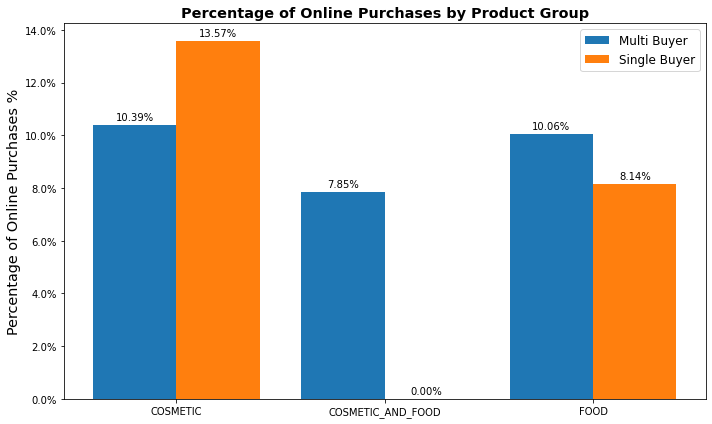

In [35]:
labels = customers_groups.loc['MULTI_BUYER'].index.values

multi_product = customers_groups.loc['MULTI_BUYER']['ONLINE_PURCHASE', 'mean'].values * 100
single_product = customers_groups.loc['SINGLE_BUYER']['ONLINE_PURCHASE', 'mean'].values * 100
single_product = np.insert(single_product, 1, 0)

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, multi_product, width, label='Multi Buyer')
rects2 = ax.bar(x + width/2, single_product, width, label='Single Buyer')

ax.set_ylabel('Percentage of Online Purchases %', fontsize = 'x-large')
ax.set_title('Percentage of Online Purchases by Product Group', fontsize='x-large', weight = 'bold')
ax.set_xticks(x, labels)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(fontsize = 'large')

ax.bar_label(rects1, padding=3, fmt='%.2f%%')
ax.bar_label(rects2, padding=3, fmt='%.2f%%')

fig.tight_layout()

plt.show()

In [36]:
customers_groups.reset_index()

CUSTOMER_GROUP      PRODUCT_GROUP ONLINE_PURCHASE                          \
                                                min max      mean       std   
0    MULTI_BUYER           COSMETIC               0   1  0.103887  0.305122   
1    MULTI_BUYER  COSMETIC_AND_FOOD               0   1  0.078515  0.268981   
2    MULTI_BUYER               FOOD               0   1   0.10057  0.300770   
3   SINGLE_BUYER           COSMETIC               0   1   0.13568  0.342455   
4   SINGLE_BUYER               FOOD               0   1  0.081443  0.273518   

                 
    sum   count  
0  1983   19088  
1  7919  100860  
2  1236   12290  
3  3300   24322  
4  2858   35092

/tmp/ipykernel_57943/3463380666.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  totals = customers_groups.reset_index().groupby('PRODUCT_GROUP').sum()['ONLINE_PURCHASE', 'sum']


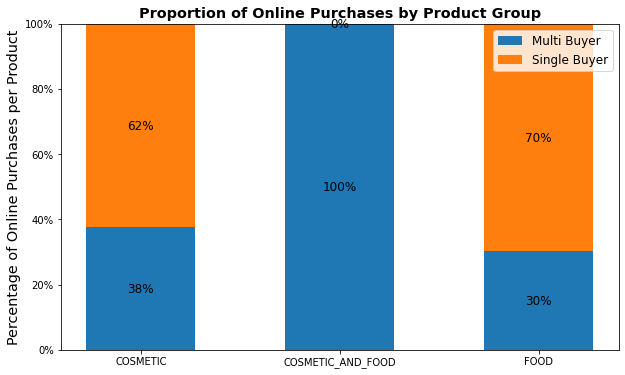

In [37]:
totals = customers_groups.reset_index().groupby('PRODUCT_GROUP').sum()['ONLINE_PURCHASE', 'sum']

labels = totals.index.values

totals = totals.values

multi_product = 100 * customers_groups.loc['MULTI_BUYER', ('ONLINE_PURCHASE', 'sum')].values / totals

single_product = customers_groups.loc['SINGLE_BUYER', ('ONLINE_PURCHASE', 'sum')].values

single_product = np.insert(single_product, 1, 0).astype('i')

single_product =100 * single_product / totals

x = np.arange(len(labels))

width = 0.55

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, multi_product, width, label='Multi Buyer')
rects2 = ax.bar(x, single_product, width, bottom = multi_product, label='Single Buyer')

ax.set_ylabel('Percentage of Online Purchases per Product', fontsize = 'x-large')
ax.set_title('Proportion of Online Purchases by Product Group', fontsize='x-large', weight = 'bold')
ax.set_xticks(x, labels)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(fontsize = 'large')

ax.bar_label(rects1, label_type='center', fmt='%.f%%', fontsize='large')
ax.bar_label(rects2, label_type='center', fmt='%.f%%', fontsize='large')

plt.show()

* Missing rows

In [38]:
miss_azdias = (azdias.isna().sum(axis=0).sort_values(ascending=False)/azdias.shape[0])[:20]

In [39]:
miss_customer = (customers.isna().sum(axis=0).sort_values(ascending=False)/customers.shape[0])[:20]

/tmp/ipykernel_57943/3605889889.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(miss_azdias.index.values, rotation=30, ha='right')
/tmp/ipykernel_57943/3605889889.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(miss_customer.index.values, rotation=30, ha='right')


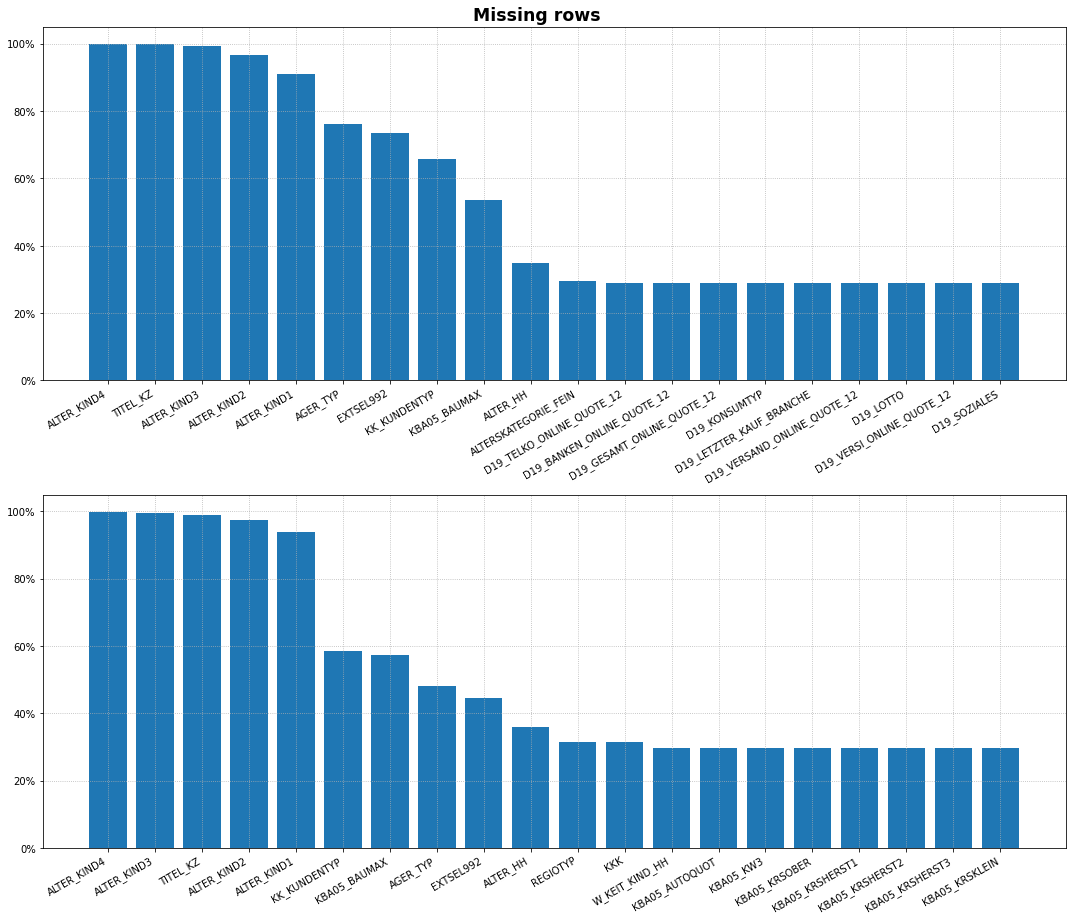

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(15,13))

ax[0].bar(miss_azdias.index.values, height = miss_azdias * 100)
ax[0].set_xticklabels(miss_azdias.index.values, rotation=30, ha='right')
ax[0].grid(True, ls = ':')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())


ax[1].bar(miss_customer.index.values, height = miss_customer * 100)
ax[1].set_xticklabels(miss_customer.index.values, rotation=30, ha='right')
ax[1].grid(True, ls = ':')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.suptitle('Missing rows', fontweight = 'bold', fontsize = 'xx-large')
fig.tight_layout()

plt.show()

* Missing columns

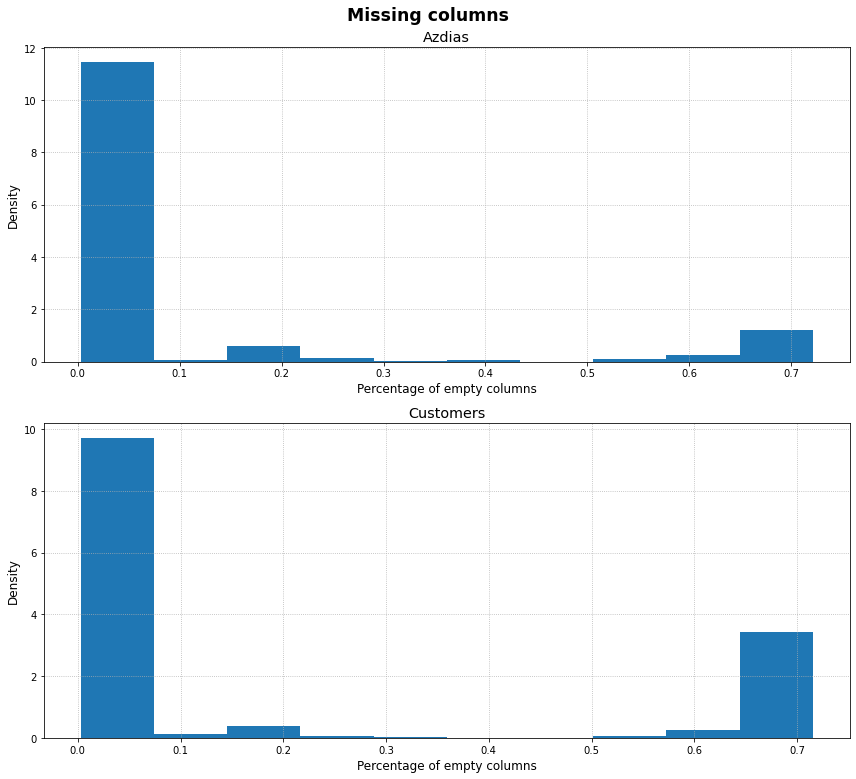

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(12,11))

ax[0].hist(azdias.isna().sum(axis=1) / azdias.shape[1], density=True)
ax[0].grid(True, ls = ':')
ax[0].set_title('Azdias', fontsize = 'x-large')
ax[0].set_xlabel('Percentage of empty columns', fontsize = 'large')
ax[0].set_ylabel('Density', fontsize = 'large')

ax[1].hist(customers.isna().sum(axis=1) / customers.shape[1], density = True)
ax[1].grid(True, ls = ':')
ax[1].set_title('Customers', fontsize = 'x-large')
ax[1].set_xlabel('Percentage of empty columns', fontsize = 'large')
ax[1].set_ylabel('Density', fontsize = 'large')

fig.suptitle('Missing columns', fontweight = 'bold', fontsize = 'xx-large')
fig.tight_layout()

plt.show()


In [42]:
azdias_nuniques.describe()

count       366.000000
mean       2461.300546
std       46584.319774
min           2.000000
25%           5.000000
50%           5.000000
75%           7.000000
max      891221.000000
dtype: float64

In [43]:
customers_nunique = customers.nunique()

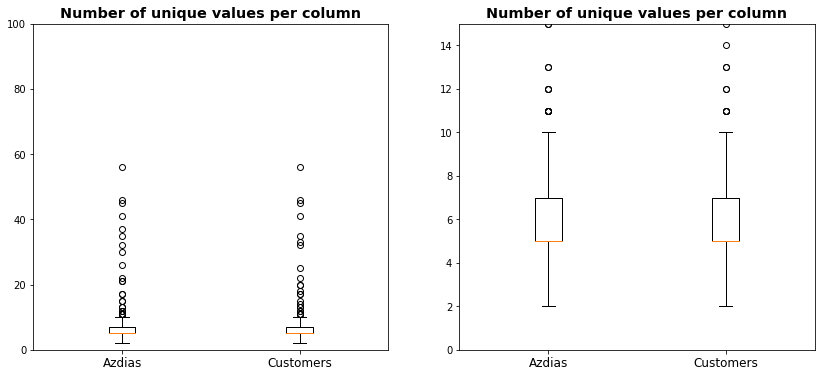

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].boxplot(x=[azdias_nuniques, customers_nunique])
ax[0].set_ylim(0, 100)
ax[0].set_title('Number of unique values per column', fontsize = 'x-large', fontweight='bold')
ax[0].set_xticklabels(labels=['Azdias', 'Customers'], fontsize = 'large')

ax[1].boxplot(x=[azdias_nuniques, customers_nunique])
ax[1].set_ylim(0, 15)
ax[1].set_title('Number of unique values per column', fontsize = 'x-large', fontweight='bold')
ax[1].set_xticklabels(labels=['Azdias', 'Customers'], fontsize = 'large')

plt.show()

In [45]:
cat_col = azdias_nuniques[azdias_nuniques<100].index.values

In [46]:
azdias.dtypes.value_counts()

Int64             360
object              5
datetime64[ns]      1
dtype: int64

In [47]:
customers.dtypes.value_counts()

Int64             361
object              7
datetime64[ns]      1
dtype: int64

In [48]:
distances = dict()
for col in cat_col:
    aux_azd = azdias[col].value_counts() / azdias.shape[0]
    aux_cust = customers[col].value_counts() / customers.shape[0]
    dfs = pd.merge(aux_azd.reset_index(), aux_cust.reset_index(), left_on='index', right_on= 'index')
    distances[col] = dfs.set_index('index').diff(axis=1).iloc[:,1].abs().sum()


In [49]:
dfs

,index,ALTERSKATEGORIE_GROB_x,ALTERSKATEGORIE_GROB_y
0,3,0.402294,0.304531
1,4,0.256401,0.447864
2,2,0.177745,0.098235
3,1,0.160327,0.148117
4,9,0.003233,0.001252


In [50]:
distances = pd.Series(distances).sort_values(ascending=False)
distances

D19_SOZIALES              0.959539
LP_LEBENSPHASE_FEIN       0.843304
CJT_TYP_6                 0.836838
CJT_TYP_5                 0.824117
KOMBIALTER                0.807964
                            ...   
D19_TELKO_ANZ_12          0.005242
D19_VERSI_ONLINE_DATUM    0.004667
D19_TELKO_ONLINE_DATUM    0.003969
ALTER_KIND3               0.000657
ALTER_KIND4               0.000210
Length: 360, dtype: float64

/tmp/ipykernel_57943/1805758785.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(distances.index.values[:20], rotation=30, ha='right')


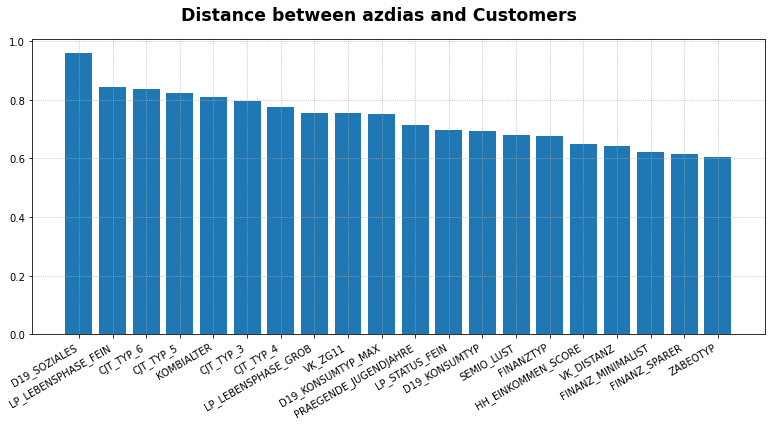

In [51]:
fig, ax = plt.subplots(figsize=(11, 6))

ax.bar(x = distances.index.values[:20], height = distances.values[:20])
ax.grid(True, ls = ':')
ax.set_xticklabels(distances.index.values[:20], rotation=30, ha='right')

fig.suptitle('Distance between azdias and Customers', fontweight = 'bold', fontsize = 'xx-large')
fig.tight_layout()

plt.show()

In [52]:
distances.describe()

count    360.000000
mean       0.222121
std        0.173442
min        0.000210
25%        0.147077
50%        0.158882
75%        0.227606
max        0.959539
dtype: float64

In [53]:
azdias[azdias_nuniques[azdias_nuniques>100].index.values].describe()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,GEBURTSJAHR,KBA13_ANZAHL_PKW
count,8.912210e+05,798073.000000,798073.000000,891221.000000,785421.000000
mean,6.372630e+05,8.287263,7.599356,1101.178533,619.701439
std,2.572735e+05,15.628087,14.332201,976.583551,340.034318
min,1.916530e+05,0.000000,0.000000,0.000000,0.000000
25%,4.144580e+05,1.000000,1.000000,0.000000,384.000000
50%,6.372630e+05,4.000000,3.000000,1943.000000,549.000000
75%,8.600680e+05,9.000000,9.000000,1970.000000,778.000000
max,1.082873e+06,595.000000,449.000000,2017.000000,2300.000000


In [54]:
customers[azdias_nuniques[azdias_nuniques > 100].index.values].describe()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,GEBURTSJAHR,KBA13_ANZAHL_PKW
count,191652.000000,141725.000000,141725.000000,191652.000000,140371.000000
mean,95826.500000,4.965863,4.701288,1003.392733,667.231216
std,55325.311233,14.309694,14.184081,974.531081,340.481722
min,1.000000,0.000000,0.000000,0.000000,5.000000
25%,47913.750000,1.000000,1.000000,0.000000,430.000000
50%,95826.500000,1.000000,1.000000,1926.000000,593.000000
75%,143739.250000,4.000000,3.000000,1949.000000,828.000000
max,191652.000000,523.000000,375.000000,2017.000000,2300.000000


In [55]:
corr = azdias.corr()

In [56]:
corr_list = corr.reset_index().melt(id_vars = 'index')

In [57]:
corr_list = corr_list.query('index != variable')

In [58]:
corr_list['var1'] = corr_list[['index', 'variable']].apply(lambda x: np.sort(np.array(x))[0], axis = 1)
corr_list['var2'] = corr_list[['index', 'variable']].apply(lambda x: np.sort(np.array(x))[1], axis = 1)

In [59]:
corr_list = corr_list.drop_duplicates(subset=['var1', 'var2'])

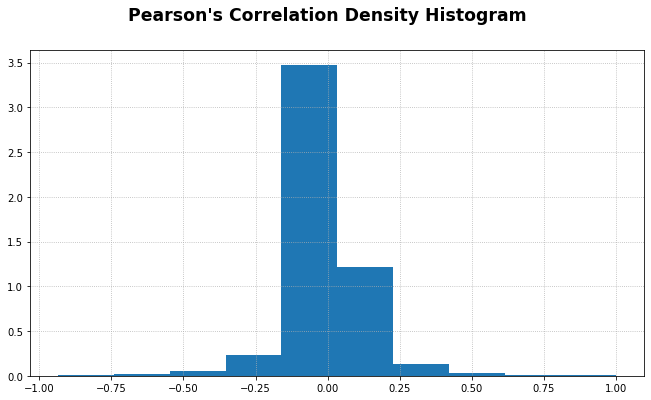

In [60]:
fig, ax = plt.subplots(figsize=(11, 6))

ax.hist(x=corr_list.value, bins = 10, density = True)
ax.grid(True, ls = ':')

fig.suptitle("Pearson's Correlation Density Histogram", fontweight = 'bold', fontsize = 'xx-large')

plt.show()

In [61]:
with open('customers_part0.pickle', 'wb') as file:
    pickle.dump(customers, file)

In [62]:
with open('azdias_part0.pickle', 'wb') as file:
    pickle.dump(azdias, file)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

One hot Enconding for the string variables

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import re
import sys
import pickle
from joblib import parallel_backend

#scikit
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
with open('azdias_part0.pickle', 'rb') as file:
    azdias = pickle.load(file)

In [4]:
azdias.shape

(891221, 366)

In [5]:
azdias = azdias.sample(n = 191_652)

From the previous session, let's perform some preparations with the data:

* Drop columns with more than 80% empty
* Drop rows with more the 60% empty

In [6]:
class myfilter(BaseEstimator):
    
    def __init__(self, thresholdcol = 0.6, thresholdrow = 0.8):
        self.thresholdcol = thresholdcol
        self.thresholdrow = thresholdrow
        
    def fit(self, X, y=None):
        cols = X.isna().sum(axis = 0)/X.shape[0]
        cols = cols[cols > self.thresholdrow].index.values
        self._cols = cols
        
        return self;
    
    def transform(self, X):
        rows = (X.isna().sum(axis=1)/X.shape[1] <= self.thresholdcol).values
        X = X[rows]
        X = X.drop(labels = self._cols, axis=1)
        
        return X
        

In [7]:
estimators = [('customfilter', myfilter()),
              ('col', ColumnTransformer([('one_hot', OneHotEncoder(), make_column_selector(dtype_include=object)), 
                                         ('min_max_scaler', MinMaxScaler(), make_column_selector(dtype_include=np.number))], remainder = 'drop')), 
              ('treat_miss', SimpleImputer(strategy="most_frequent"))]

In [8]:
prep = Pipeline(estimators)

In [9]:
pca = PCA(2)

In [10]:
kmeans = KMeans(8)

In [11]:
with parallel_backend('threading', n_jobs=2):
    %time azdias_res = prep.fit_transform(azdias)
    azdias_pca = pca.fit_transform(azdias_res)

CPU times: user 2min 1s, sys: 979 ms, total: 2min 2s
Wall time: 2min 1s


In [12]:
with open('customers_part0.pickle', 'rb') as file:
    customers = pickle.load(file)

Dropping different columns in customers

In [13]:
customers = customers.drop(labels = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

In [14]:
with parallel_backend('threading', n_jobs=2):
    %time customers_res = prep.fit_transform(customers)
    customers_pca = pca.transform(customers_res)

CPU times: user 5.19 s, sys: 1.48 s, total: 6.67 s
Wall time: 6.66 s


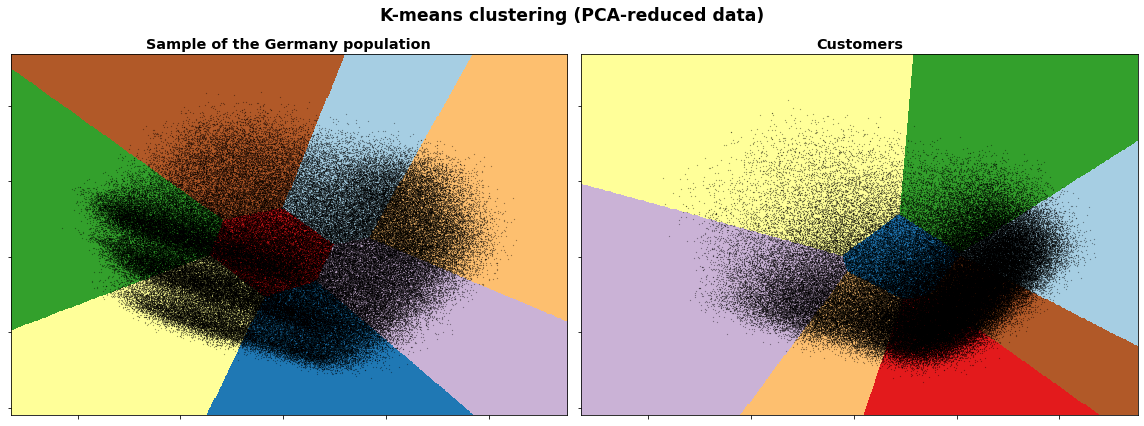

In [15]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = azdias_pca[:, 0].min() - 1, azdias_pca[:, 0].max() + 1
y_min, y_max = azdias_pca[:, 1].min() - 1, azdias_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

kmeans.fit(azdias_pca)

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

kmeans.fit(customers_pca)
Z_cust = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

fig, ax = plt.subplots(1, 2, figsize=(16,6))

Z = Z.reshape(xx.shape)
ax[0].imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)
Z_cust = Z_cust.reshape(xx.shape)
ax[1].imshow(
    Z_cust,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

ax[0].plot(azdias_pca[:, 0], azdias_pca[:, 1], "k.", markersize=0.3)
ax[1].plot(customers_pca[:, 0], customers_pca[:, 1], "k.", markersize=0.3)

fig.suptitle("K-means clustering (PCA-reduced data)", fontweight = 'bold', fontsize = 'xx-large')
ax[0].set_title("Sample of the Germany population", fontweight = 'bold', fontsize = 'x-large')
ax[1].set_title("Customers", fontweight = 'bold', fontsize = 'x-large')

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])

plt.tight_layout()
plt.show()

In [41]:
azd_k = pd.Series(kmeans.fit_predict(azdias_pca))

In [42]:
cust_k = pd.Series(kmeans.fit_predict(customers_pca))

In [44]:
azd_k.value_counts()/azd_k.shape

7    0.157010
0    0.150036
1    0.149920
4    0.144923
5    0.126393
6    0.100475
2    0.098796
3    0.072447
dtype: float64

In [45]:
cust_k.value_counts()/cust_k.shape

2    0.199217
1    0.193205
7    0.150557
3    0.115926
0    0.114500
5    0.088625
4    0.088597
6    0.049372
dtype: float64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')